In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

In [4]:
df = pd.read_csv("/Users/calvi/Downloads/Airbnb_Open_Data.csv")
print(df.shape)
print(df.columns)
df.head()


(102599, 26)
Index(['id', 'NAME', 'host id', 'host_identity_verified', 'host name',
       'neighbourhood group', 'neighbourhood', 'lat', 'long', 'country',
       'country code', 'instant_bookable', 'cancellation_policy', 'room type',
       'Construction year', 'price', 'service fee', 'minimum nights',
       'number of reviews', 'last review', 'reviews per month',
       'review rate number', 'calculated host listings count',
       'availability 365', 'house_rules', 'license'],
      dtype='object')


/var/folders/8_/_mkv7dtj7hvfvhvj31qsy35h0000gn/T/ipykernel_3854/2292675285.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/calvi/Downloads/Airbnb_Open_Data.csv")


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [9]:
#function to clean the money columns
def clean_money(x):
    if pd.isna(x):
        return np.nan
    s = re.sub(r"[^0-9.]", "", str(x))
    return float(s) if s else np.nan

# Clean price (+ service fee if you want it later)
df["price"] = df["price"].apply(clean_money)
if "service fee" in df.columns:
    df["service fee"] = df["service fee"].apply(clean_money)

# Keep positive prices only
df = df[(df["price"].notna()) & (df["price"] > 0)].copy()

# Log-transform target for stability
df["log_price"] = np.log1p(df["price"])

df[["price", "log_price"]].describe(percentiles=[.01, .05, .5, .95, .99])

,price,log_price
count,102352.000000,102352.000000
mean,625.293536,6.232023
std,331.671614,0.732649
min,50.000000,3.931826
1%,61.000000,4.127134
5%,108.000000,4.691348
50%,624.000000,6.437752
95%,1143.000000,7.042286
99%,1188.000000,7.080868
max,1200.000000,7.090910


In [10]:
candidates = [
    "room type",
    "neighbourhood group",
    "minimum nights",
    "number of reviews",
    "review rate number",
    "availability 365",
]
features = [c for c in candidates if c in df.columns]
print("Using features:", features)

# Drop rows with missing feature values (simple for draft)
df_model = df.dropna(subset=features).copy()

X = df_model[features]
y = df_model["log_price"]

X.head(3)

Using features: ['room type', 'neighbourhood group', 'minimum nights', 'number of reviews', 'review rate number', 'availability 365']


,room type,neighbourhood group,minimum nights,number of reviews,review rate number,availability 365
0,Private room,Brooklyn,10.0,9.0,4.0,286.0
1,Entire home/apt,Manhattan,30.0,45.0,4.0,228.0
2,Private room,Manhattan,3.0,0.0,5.0,352.0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_train.shape, X_test.shape


((80861, 6), (20216, 6))

In [14]:
cat_cols = [c for c in features if df_model[c].dtype == "object"]
num_cols = [c for c in features if c not in cat_cols]


ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
pre = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
)

cat_cols, num_cols

(['room type', 'neighbourhood group'],
 ['minimum nights',
  'number of reviews',
  'review rate number',
  'availability 365'])

In [15]:
linreg = Pipeline(steps=[
    ("pre", pre),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)


In [20]:
rmse_log = root_mean_squared_error(y_test, y_pred)
mae_log  = mean_absolute_error(y_test, y_pred)
r2       = r2_score(y_test, y_pred)

print({
    "RMSE_log": round(rmse_log, 4),
    "MAE_log": round(mae_log, 4),
    "R2": round(r2, 4),
})


{'RMSE_log': 0.7349, 'MAE_log': 0.5885, 'R2': 0.0001}


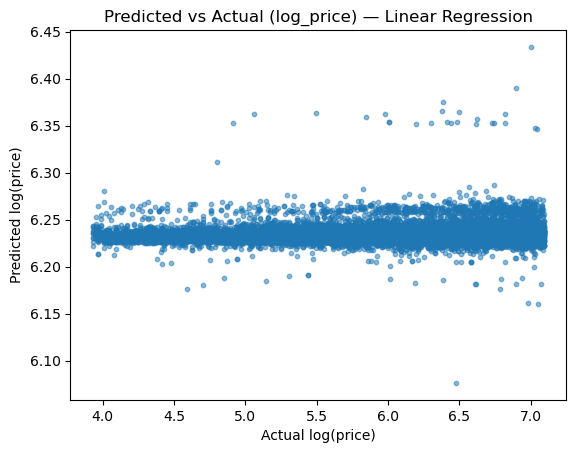

In [21]:
plt.figure()
plt.scatter(y_test, y_pred, s=10, alpha=0.5)
plt.title("Predicted vs Actual (log_price) — Linear Regression")
plt.xlabel("Actual log(price)")
plt.ylabel("Predicted log(price)")
plt.show()
